# Replicate SRCNN

LS2N-SIMS - Ecole Centrale Nantes

Supervisor: **Diana Mateus**

Student: **Wenrui Li**

### Introduction

In this notebook, we will replicate the SRCNN model proposed by Chao DONG et al.

Website: http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

### 1. Load modules and data

#### 1.1 Import modules

In [1]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Keras and related modules
import keras
from keras import backend as K                        #https://keras.io/backend/
import tensorflow as tf

#Layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda                       #Lambda wraps arbitrary expression as a Layer object.
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import add, concatenate
from keras import regularizers
from keras.initializers import he_normal, glorot_normal, RandomNormal

#To save and reload models, to modify model parameters by callbacks
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.utils import multi_gpu_model, plot_model

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator    

#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

#Scipy
import scipy.misc

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
print('Scipy        :', scipy.__version__)

Using TensorFlow backend.


Python       : 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]
Numpy        : 1.15.2
Skimage      : 0.14.2
Scikit-learn : 0.20.0
Keras        : 2.2.4
Tensorflow   : 1.12.0
Scipy        : 1.1.0


#### 1.2 Define global parameters
- Set seed for random values to a fix number (42) to ensure that we get images and labels that correspond to each other.
- Define the SR factor 
- Define the input image size
``` img_height, img_width ```
- Define the full image size (where the input images are cut from)
- Define the stride for cutting sub-images from the full images and the stride for cutting full images from the original images
- Define the number of color channels, 1 for gray images and Y channel images,3 for RGB images

In [2]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set number of GPUs
num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set the SR factor, usually 2, 3 or 4
SR_factor = 3

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (33,33) if SR_factor == 3 else (32,32)
img_hei_full, img_wid_full = (192,192) if SR_factor == 3 else (256,256)

# Set stride for cutting sub images
cut_stride = 14
cut_str_full = img_hei_full

# Set number of color channels
chan_num = 1

#### 1.3 Import data 

#### 1.3.1 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [3]:
#4S
topDir = "C:/Users/ruizhi/Desktop/internship/u_net_SR" 
os.chdir(topDir)    
print(os.listdir(os.path.join(topDir, 'input')))  #see what's in the input folder (where data is in)
train_path = os.path.join(topDir, 'input/train/T91')  #path to training data file/folder
test_path = os.path.join(topDir, 'input/test/Set5')   #path to test data file/folder
valid_path = os.path.join(topDir, 'input/test/Set5')  #path to validation data file/folder

['test', 'train']


#### 1.3.2 Read and preload the HR image data

Read the data and create a tensor containing all the ground truth images (HR images).

Create a function ``get_HR_images`` that 
- receives as input an image path (can be train, validation or test).
- lists all files in the input image path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread`` or ``skimage.io.ImageCollection``
- use only the first three channels of the images.
- return a numpy array (matrix) .
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [4]:
def modcrop(image, scale=SR_factor):
    if len(image.shape) == 3: # 3 channel image
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:  # 1 channel image
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [5]:
%%time
# Get HR data
def get_HR_images(path):
    
    HR_img = []
    
    #Loads images from path/{id}.jpg into a numpy array
    img_paths = ['{0}/{1}'.format(path, id) for id in os.listdir(path)]
    
    ic = skimage.io.ImageCollection(load_pattern=img_paths)
    
    for im in ic:
        im = skimage.color.rgb2ycbcr(im)
        im = im[:,:,0]/255.0 # super-resolve Y channel only, transfer uint8 to double
        im = modcrop(im, SR_factor)
        
        (h,w) = im.shape
        for x in range(0,h-img_hei_full+1,cut_str_full):
                    for y in range(0,w-img_wid_full+1,cut_str_full):
                                im_full = im[x : x+img_hei_full, y : y+img_wid_full]
                                HR_img.append(im_full)
    HR_img = np.array(HR_img)
    HR_img = HR_img.reshape(HR_img.shape[0],HR_img.shape[1],HR_img.shape[2],chan_num)
    return HR_img

HR_train = get_HR_images(train_path)
print('HR training images:', HR_train.shape, HR_train.dtype)

HR_test = get_HR_images(test_path)
print('HR test images:', HR_test.shape, HR_test.dtype)

HR_valid = get_HR_images(valid_path)
print('HR validation images:', HR_valid.shape, HR_valid.dtype)

HR training images: (54, 192, 192, 1) float64
HR test images: (8, 192, 192, 1) float64
HR validation images: (8, 192, 192, 1) float64
Wall time: 2.89 s


#### 1.3.3 Process the HR image data to acquire LR images
Create a tensor containing all the LR images.

Create a function ``get_LR_images`` that
- receives as input a HR image array (can be train or test)
- blur the image with a Gaussian kernel (sigma = 1).
- downsample the images with bicubic interpolation. 
- implement bicubic interpolation to upscale the LR image to the size of the HR ones.
- return a numpy array (matrix) .
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [6]:
%%time
# Get LR data
def get_LR_images(HR_data):
    
    LR_img = []
    
    for i in range(HR_data.shape[0]):
        #blurred_i = skimage.filters.gaussian(HR_data[i,:,:,:],sigma=1,multichannel=False if chan_num == 1 else True)
        blurred_i = HR_data[i,:,:,:]
        downsampled_i = scipy.misc.imresize(blurred_i.reshape(blurred_i.shape[0],blurred_i.shape[1]),
                        1/SR_factor, interp='bicubic', mode=None)
        interpolated_i = scipy.misc.imresize(downsampled_i, (img_hei_full,img_wid_full), interp='bicubic', mode=None)
        LR_img.append(interpolated_i)

    LR_img = np.array(LR_img)
    LR_img = LR_img.reshape(LR_img.shape[0],LR_img.shape[1],LR_img.shape[2],chan_num)
    return LR_img/255.0

LR_train = get_LR_images(HR_train)
print('LR training images:', LR_train.shape, LR_train.dtype)

LR_test = get_LR_images(HR_test)
print('LR test images:', LR_test.shape, LR_test.dtype)

LR_valid = get_LR_images(HR_valid)
print('LR valid images:', LR_valid.shape, LR_valid.dtype)


LR training images: (54, 192, 192, 1) float64
LR test images: (8, 192, 192, 1) float64
LR valid images: (8, 192, 192, 1) float64
Wall time: 147 ms


D:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
D:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


#### 1.3.4 Cut HR and LR full images into smaller sub-images

In [7]:
%%time
# Get LR data
def get_LR_images(HR_data):
    
    LR_img = []
    
    for i in range(HR_data.shape[0]):
        #blurred_i = skimage.filters.gaussian(HR_data[i,:,:,:],sigma=1,multichannel=False if chan_num == 1 else True)
        blurred_i = HR_data[i,:,:,:]
        downsampled_i = scipy.misc.imresize(blurred_i.reshape(blurred_i.shape[0],blurred_i.shape[1]),
                        1/SR_factor, interp='bicubic', mode=None)
        interpolated_i = scipy.misc.imresize(downsampled_i, (img_hei_full,img_wid_full), interp='bicubic', mode=None)
        LR_img.append(interpolated_i)

    LR_img = np.array(LR_img)
    LR_img = LR_img.reshape(LR_img.shape[0],LR_img.shape[1],LR_img.shape[2],chan_num)
    return LR_img/255.0

LR_train = get_LR_images(HR_train)
print('LR training images:', LR_train.shape, LR_train.dtype)

LR_test = get_LR_images(HR_test)
print('LR test images:', LR_test.shape, LR_test.dtype)

LR_valid = get_LR_images(HR_valid)
print('LR valid images:', LR_valid.shape, LR_valid.dtype)

def get_sub_images(full_img_array):
    sub_img_list = []
    l = full_img_array.shape[0]
    h = full_img_array.shape[1]
    w = full_img_array.shape[2]
    
    for i in range(l):
        im = full_img_array[i,:,:,:]
        
        for x in range(0,h-img_height+1,cut_stride):
            for y in range(0,w-img_width+1,cut_stride):
                im_sub = im[x : x+img_height, y : y+img_width]
                sub_img_list.append(im_sub)
    
    sub_img_array = np.array(sub_img_list)
    #HR_img = HR_img.reshape(HR_img.shape[0],HR_img.shape[1],HR_img.shape[2],chan_num)
    return sub_img_array

HR_train_sub = get_sub_images(HR_train)
print('HR train sub images:', HR_train_sub.shape, HR_train_sub.dtype)
LR_train_sub = get_sub_images(LR_train)
print('LR train sub images:', LR_train_sub.shape, LR_train_sub.dtype)

HR_valid_sub = get_sub_images(HR_valid)
print('HR validation sub images:', HR_valid_sub.shape, HR_valid_sub.dtype)
LR_valid_sub = get_sub_images(LR_valid)
print('LR validation sub images:', LR_valid_sub.shape, LR_valid_sub.dtype)

HR train sub images: (5400, 33, 33, 1) float64
LR train sub images: (5400, 33, 33, 1) float64
HR validation sub images: (5100, 33, 33, 1) float64
LR validation sub images: (5100, 33, 33, 1) float64


#### 1.3.5 Cut original images and LR images into smaller sub-images

If use this function, ignore 1.3.2, 1.3.3 and 1.3.4

In [7]:
%%time
def get_images(path):
    
    HR_img = []
    LR_img = []
    
    #Loads images from path/{id}.jpg into a numpy array
    img_paths = ['{0}/{1}'.format(path, id) for id in os.listdir(path)]
    
    ic = skimage.io.ImageCollection(load_pattern=img_paths)
    print(len(ic))
    
    for im in ic:
        im = skimage.color.rgb2ycbcr(im)
        im = im[:,:,0]/255.0 # super-resolve Y channel only, transfer uint8 to double
        im = modcrop(im, SR_factor)
        
        (h,w) = im.shape
        downsampled_i = scipy.misc.imresize(im, 1/SR_factor, interp='bicubic', mode=None)
        interpolated_i = scipy.misc.imresize(downsampled_i, (h,w), interp='bicubic', mode=None)
        
        for x in range(0,h-img_height+1,cut_stride):
            for y in range(0,w-img_width+1,cut_stride):
                hr_sub = im[x : x+img_height, y : y+img_width]
                lr_sub = interpolated_i[x : x+img_height, y : y+img_width]
                HR_img.append(hr_sub)
                LR_img.append(lr_sub)
    
    HR_img = np.array(HR_img)
    HR_img = HR_img.reshape(HR_img.shape[0],HR_img.shape[1],HR_img.shape[2],chan_num)
    LR_img = np.array(LR_img)
    LR_img = LR_img.reshape(LR_img.shape[0],LR_img.shape[1],LR_img.shape[2],chan_num)
    return HR_img, LR_img/255.0

HR_train_sub,LR_train_sub = get_images(train_path)
print('HR train sub images:', HR_train_sub.shape, HR_train_sub.dtype)
print('LR train sub images:', LR_train_sub.shape, LR_train_sub.dtype)

HR_valid_sub,LR_valid_sub = get_images(valid_path)
print('HR validation sub images:', HR_valid_sub.shape, HR_valid_sub.dtype)
print('LR validation sub images:', LR_valid_sub.shape, LR_valid_sub.dtype)

91


D:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
D:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


HR train sub images: (21884, 33, 33, 1) float64
LR train sub images: (21884, 33, 33, 1) float64
5
HR validation sub images: (2488, 33, 33, 1) float64
LR validation sub images: (2488, 33, 33, 1) float64
Wall time: 2.44 s


#### 1.4 Visualize some examples of images and matching labels
Choose one index among the list and use ``plt.imshow`` to visualize side by side the corresponding HR image and LR image.

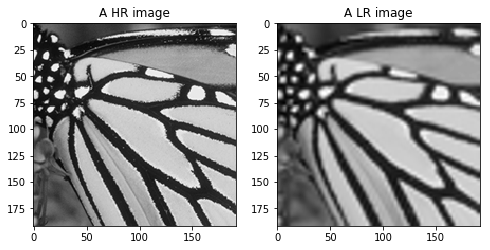

In [8]:
# Choose an image
ind = 5

if chan_num == 1:
    HR_ex=HR_test[ind,:,:,:].reshape(img_hei_full,img_wid_full)
    LR_ex=LR_test[ind,:,:,:].reshape(img_hei_full,img_wid_full)
else:
    HR_ex=HR_test[ind,:,:,:]
    LR_ex=LR_test[ind,:,:,:]

plt.rcParams['figure.figsize']=(8,8)
plt.figure()
plt.subplot(121)
plt.imshow(HR_ex,cmap='gray')
plt.title("A HR image")
plt.subplot(122)
plt.imshow(LR_ex,cmap='gray')
plt.title("A LR image")
plt.show()

### 2. Buidling the SRCNN model
#### 2.1. Define the architecture

In [11]:
# Define SRCNN architecture here
def SRCNN_model(img_width, img_height):
    
    #define the architecture parameters
    n_channels = [64,32,chan_num]  #the number of kernels/feature channels per layer
    k_size = [9,1,5]                   #size of filter kernel
    k_init = RandomNormal(mean=0.0, stddev=0.001, seed=42)#glorot_normal(seed=42) # Initialization of SRCNN (Chao Dong et al.)
    
    # Use Keras Input layer to create one
    inp = Input((img_width, img_height,chan_num))
    #inp = Input((img_wid_full, img_hei_full,chan_num))
    
    # Convolutional Layer #1
    conv1 = Conv2D(filters=n_channels[0], kernel_size=k_size[0], padding="same", data_format="channels_last",
                   activation='relu', kernel_initializer=k_init)(inp)
    
    # Convolutional Layer #2
    conv2 = Conv2D(filters=n_channels[1], kernel_size=k_size[1], padding="same", data_format="channels_last",
                   activation='relu', kernel_initializer=k_init)(conv1)
    
    # Output
    outp = Conv2D(filters=n_channels[2], kernel_size=k_size[2], padding="same", data_format="channels_last",
                  activation=None, kernel_initializer=k_init)(conv2)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    return model

#### 2.2. Define the losses and metrics

In [12]:
#MSE loss
def mse_loss(hr_img, sr_img):
    mse=K.mean(K.abs(hr_img-sr_img)**2)
    return mse

#Compute log10
def log10(x):
    numerator = K.log(x)
    denominator = K.log(K.constant(10, dtype=numerator.dtype))
    return numerator / denominator

#PSNR metric
def psnr(hr_img, sr_img):
    psnr = 20 * log10(1.0 / K.sqrt(mse_loss(hr_img, sr_img)))
    return psnr

#SSIM metric
def ssim(hr_img, sr_img):
    mu_h = K.mean(hr_img)
    mu_s = K.mean(sr_img)
    sig_h = K.std(hr_img)
    sig_s = K.std(sr_img)
    cov_hs = K.mean((hr_img-mu_h) * (sr_img-mu_s))
    
    c1 = 0.01**2
    c2 = 0.03**2
    
    ssim = (2*mu_h*mu_s + c1)*(2*cov_hs + c2)/(mu_h**2 + mu_s**2 + c1)/(sig_h**2 + sig_s**2 + c2)
    return ssim

#### 2.3 Define optimizer 

In [13]:
# Set some model compile parameters
optimizer = keras.optimizers.SGD(lr=0.1,momentum=0.9)#Adam(lr=0.0001)
loss      = 'mean_squared_error'#mse_loss #"mean_absolute_error"
metrics   = [psnr,ssim]

#### 2.4 Compile the model

In [14]:
# Compile the model and list its structure
model = SRCNN_model(img_width, img_height)
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 33, 33, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 64)        5248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 32)        2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


### 3. Trainning
#### 3.1 Train with visualization of the losses
#### 3.1.1 Use self-defined functions to visualize training process

In [15]:
path1 = '_Factor' + str(SR_factor)
path2 = '_FullImg' if model.layers[0].input_shape[1] > 33 else '_SubImg'
lr_decay = False           # whether use learning rate decay or not
path3 = '_LRDecay' if lr_decay == True else '_LRFixed'

savename = path1 + path2 + path3

In [16]:
#4S
# Runtime custom callbacks for loss visualization
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Loss", 'psnr': "PSNR(dB)", 'ssim': "SSIM", 'mse_loss': "Loss"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.LR = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())
        self.LR.append(K.get_value(self.model.optimizer.lr))
        
        metric_dir = "./saved_metrics"
        metric_path = 'metrics' + savename + '.svg'

        if not os.path.isdir(metric_dir):
            os.makedirs(metric_dir)

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        #if weight_decay == None:
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(2, (len(self.base_metrics)+1)/2, metric_id + 1)
            plt.grid()

            plt.plot(range(1, len(self.logs) + 1),
                        [log[metric] for log in self.logs],
                        marker="o", label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                            [log['val_' + metric] for log in self.logs],
                            marker="o", label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center right')
            
        plt.subplot(2, (len(self.base_metrics)+1)/2, len(self.base_metrics)+1)
        '''
        else:
            for metric_id, metric in enumerate(self.base_metrics):
                if metric != 'loss':
                    plt.subplot(2, (len(self.base_metrics)+1)/2, metric_id)
                    plt.grid()

                    plt.plot(range(1, len(self.logs) + 1),
                             [log[metric] for log in self.logs],
                             marker="o", label="training")
                    if self.params['do_validation']:
                        plt.plot(range(1, len(self.logs) + 1),
                                 [log['val_' + metric] for log in self.logs],
                                 marker="o", label="validation")
                    plt.title(translate_metric(metric))
                    plt.xlabel('epoch')
                    plt.legend(loc='center right')
            
            plt.subplot(2, (len(self.base_metrics))/2, len(self.base_metrics))
        '''      
        #plt.subplot(2, (len(self.base_metrics)+1)/2, len(self.base_metrics)+1)
        plt.grid()
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.plot(range(1, len(self.logs) + 1),self.LR,marker="o")
        plt.title('Learning rate')
        plt.xlabel('epoch')
        
        plt.tight_layout()
        plt.savefig(os.path.join(metric_dir, metric_path),format='svg', dpi=1200)
        plt.show();
        
plot_losses = PlotLosses(figsize=(12.8, 8))

#### 3.2 Launch the training
- Use the model.fit function. 
- Save the final model. 
- Measure the overall time.

#### 3.2.1 Training

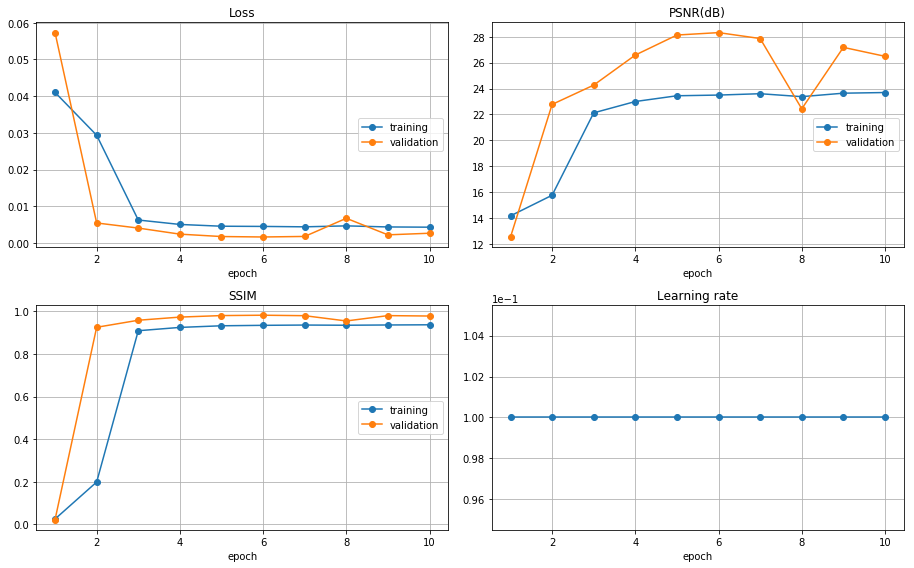


Epoch 00010: val_loss did not improve from 0.00165

Epoch 00010: val_loss did not improve from 0.00165
Wall time: 1h 5min 48s


In [17]:
%%time

epochs=10
batch_size=128

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./saved_model"
weight_dir = "./saved_weights"
model_path = 'model' + savename + '.hdf5'
weight_path = 'weights' + savename + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=False, mode='min')
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=True,
                              save_weights_only=True, mode='min')

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.001)

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 10 epochs
        if epoch % 20 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Fit
plt.ioff()
hist=model.fit(x=LR_train_sub, y=HR_train_sub, batch_size=batch_size, epochs=epochs,
               callbacks=cb_list, validation_data=(LR_valid_sub,HR_valid_sub))#validation_split=0.1
plt.close('all')
plt.ion()

#### 3.2.3 Save the training history for further use

In [18]:
import pickle
# Save
hist_dir = "./saved_history"
hist_path = 'TrainHistory' + savename

if not os.path.isdir(hist_dir):
    os.makedirs(hist_dir)    

with open(os.path.join(hist_dir, hist_path), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# Load (optional)
#with open('TrainHistory', 'rb') as file_pi:
#    hist_loaded = pickle.load(file_pi)

### 4. Test phase
#### 4.1 Reload the model and the test data
Reload the keras model and fill it with the saved weights ``model_loaded.load_weights``

In [19]:
# Select which model to load
path1 = '_Factor' + str(SR_factor)
path2 = '_SubImg'
lr_decay = False           # whether use learning rate decay or not
path3 = '_LRDecay' if lr_decay == True else '_LRFixed'

loadname = path1 + path2 + path3
load_path = 'weights' + loadname + '.h5'

load_dir = "./saved_weights"
load_path = os.path.join(load_dir, load_path)

model_loaded = SRCNN_model(img_width=img_wid_full, img_height=img_hei_full)# Test images are not cut, so input size should be modified
model_loaded.load_weights(load_path)
model_loaded.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### 4.2 Use model to predict test labels

In [20]:
#4S
SR_test = model_loaded.predict(LR_test, verbose=1)
print(SR_test.shape, SR_test.dtype)

8/8 [==============================] - 1s 181ms/step
(8, 192, 192, 1) float32


#### 4.3 Compute metrics on test set

In [21]:
# Compute PSNR on test set
def compute_psnr(hr_img, sr_img):
    mse=np.mean(abs(sr_img-hr_img)**2)
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

def compute_ssim(hr_img, sr_img):
    mu_h = np.mean(hr_img)
    mu_s = np.mean(sr_img)
    sig_h = np.std(hr_img)
    sig_s = np.std(sr_img)
    cov_hs = np.mean((hr_img-mu_h) * (sr_img-mu_s))
    
    c1 = 0.01**2
    c2 = 0.03**2
    
    ssim = (2*mu_h*mu_s + c1)*(2*cov_hs + c2)/(mu_h**2 + mu_s**2 + c1)/(sig_h**2 + sig_s**2 + c2)
    return ssim

psnr_bicubic=[]
psnr_sr=[]
ssim_bicubic=[]
ssim_sr=[]

for i in range(LR_test.shape[0]):
    psnr_bicubic.append(compute_psnr(HR_test[i,:,:,:],LR_test[i,:,:,:]))
    psnr_sr.append(compute_psnr(HR_test[i,:,:,:],SR_test[i,:,:,:]))
    ssim_bicubic.append(compute_ssim(HR_test[i,:,:,:],LR_test[i,:,:,:]))
    ssim_sr.append(compute_ssim(HR_test[i,:,:,:],SR_test[i,:,:,:]))

print('bicubic psnr on test set:',psnr_bicubic,'dB')
print('SR psnr on test set:',psnr_sr,'dB')
print('bicubic ssim on test set:',ssim_bicubic)
print('SR ssim on test set:',ssim_sr)

bicubic psnr on test set: [24.012539158098303, 19.247809596839474, 25.556096383232912, 17.48136360218712, 26.880922163153965, 21.390061430848494, 19.02023802712381, 19.281184854650185] dB
SR psnr on test set: [26.0444701243593, 26.693952557510855, 27.82000839221599, 28.633000586912097, 30.138808861349617, 23.83201268566177, 21.639009866340473, 25.880230573472925] dB
bicubic ssim on test set: [0.9722756251662846, 0.9292801792785076, 0.9773051944131002, 0.9343215443007971, 0.9685635713404963, 0.9402530285502827, 0.854088963720008, 0.9460112456213209]
SR ssim on test set: [0.9912709593233755, 0.9832606922838101, 0.9934767610322197, 0.9893541151135185, 0.9868002727847778, 0.9626567340578895, 0.9166477967083705, 0.9793028561576499]


#### 4.4 Visualize predictions on a random element of the test data

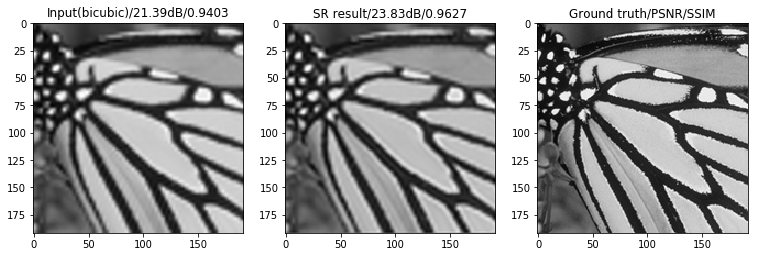

In [22]:
# Choose an image
ind = 5

if chan_num == 1:
    HR_ex=HR_test[ind,:,:,:].reshape(img_hei_full,img_wid_full)
    LR_ex=LR_test[ind,:,:,:].reshape(img_hei_full,img_wid_full)
    SR_ex=SR_test[ind,:,:,:].reshape(img_hei_full,img_wid_full)
else:
    HR_ex=HR_test[ind,:,:,:]
    LR_ex=LR_test[ind,:,:,:]
    SR_ex=SR_test[ind,:,:,:]

result_dir = "./saved_results"
result_path = 'result' + loadname + '.svg'

if not os.path.isdir(result_dir):
    os.makedirs(result_dir)

plt.rcParams['figure.figsize']=(12.8,12.8)
plt.figure()
plt.subplot(131)
plt.imshow(LR_ex,cmap='gray')
plt.title("Input(bicubic)/{0:.2f}dB/{1:.4f}".format(psnr_bicubic[ind],ssim_bicubic[ind]))
plt.subplot(132)
plt.imshow(SR_ex,cmap='gray')
plt.title("SR result/{0:.2f}dB/{1:.4f}".format(psnr_sr[ind],ssim_sr[ind]))
plt.subplot(133)
plt.imshow(HR_ex,cmap='gray')
plt.title("Ground truth/PSNR/SSIM")
plt.savefig(os.path.join(result_dir, result_path), format='svg',dpi=1200)
plt.show()